## Deconvolving single-cell family size distribution into chimeric and real components

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from sc_fingerprint import SingleCellFingerprint, SingleCellFingerprintDataStore
from sc_fsd_codec import GeneralNegativeBinomialMixtureFamilySizeDistributionCodec
from sc_fsd_mixture_model import SingleCellFamilySizeModel

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import ZeroInflatedNegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [43]:
# dataset_name = 'pbmc4k_ss_rate_0.25'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'

dataset_name = 'pbmc4k'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'

zinb_fitter_kwargs = {
    'lr': 0.5,
    'max_iters': 10_000,
    'p_zero_l1_reg': 0.001,
    'outlier_stringency': 5.0,
    'max_zinb_p_zero': 0.9995,
    'min_zinb_p_zero': 0.0005,
    'min_nb_phi': 0.01,
    'max_nb_phi': 0.95
}


# # generate a gene expression ladder for testing the full dynamic range
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_ladder_idx_list = all_genes_default_filter[::100]

# # Instantiate the fingerprint datastore
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     gene_idx_list=gene_expr_ladder_idx_list,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)


# load fingerprint and instantiate the data-store
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint = sc_fingerprint.filter_genes()

# Instantiate the fingerprint datastore
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint,
    top_k_genes=sc_fingerprint.num_genes,
    n_gene_groups=100,
    zinb_fitter_kwargs=zinb_fitter_kwargs,
    max_estimated_chimera_family_size=0)


# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint, top_k_genes=50, n_gene_groups=10, zinb_fitter_kwargs=zinb_fitter_kwargs)

# # generate top 200 genes
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_top_200_idx_list = all_genes_default_filter[:200]

# # Instantiate the fingerprint datastore
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     gene_idx_list=gene_expr_top_200_idx_list,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)

## Model, training, and regularization configuration

In [119]:
n_iters = 10_000

mb_genes_per_gene_group = 20
mb_expressing_cells_per_gene = 20
mb_silent_cells_per_gene = 1

init_params_dict = {
    'chimera.alpha_c': 0.0,
    'chimera.beta_c': 0.5,
    'fsd.gmm_num_components': 5,
    'fsd.gmm_dirichlet_concentration': 1.0,
    'fsd.gmm_min_weight_per_component': 1e-3,
    'fsd.gmm_init_xi_scale': 1.5,
    'fsd.gmm_min_xi_scale': 0.1,
    'fsd.gmm_init_components_perplexity': 0.5,
    'fsd.enable_fsd_w_dirichlet_reg': True,
    'fsd.enable_gmm_scale_optimization': True,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.001,
    'fsd.w_hi_dirichlet_concentration': 0.001,
    'fsd.xi_posterior_min_scale': 0.0,
    'chimera.enable_hyperparameter_optimization': False,
    'model.fingerprint_log_likelihood_n_particles': 1
}


fsd_init_params_dict = {
    'fsd_init.min_mu_lo': 0.02,
    'fsd_init.min_mu_hi': 0.2,
    'fsd_init.max_phi_lo': 1.5,
    'fsd_init.max_phi_hi': 0.5,
    'fsd_init.mu_decay': 0.75,
    'fsd_init.w_decay': 0.2,
    'fsd_init.mu_lo_to_mu_hi_ratio': 0.05}


model_constraint_params_dict = {
    # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
    'phi_lo_comps': {
        'pin_value': 1.0,
        'pin_strength': 1e8,
        'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_hi_comps': {
        'upper_bound_value': 0.5,
        'upper_bound_width': 0.1,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # no component of p_lo can have too small or too large of a mean family size compared to the empirical mean
    'mu_lo_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 0.1,
        'upper_bound_width': 0.01,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size compared to the empirical mean
    'mu_hi_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.3,
        'lower_bound_width': 0.1,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'p_obs_lo_to_p_obs_hi_ratio': {
        'upper_bound_value': 0.2,
        'upper_bound_width': 0.05,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_hi_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_lo_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},

    # make sure that phi_e_hi is not too small or too large (to prevent over/under-flows)
    'phi_e_hi_batch': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # make sure that logit_p_zero_e_hi_batch is not too small or too large (to prevent over/under-flows)
    'logit_p_zero_e_hi_batch': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
}


def adam_args(module_name, param_name):
    slow_lr = 2e-3
    slow_params = {
        'alpha_c', 'beta_c',
        'mu_e_lo', 'phi_e_lo',
        'mu_e_hi', 'phi_e_hi', 'logit_p_zero_e_hi',
        'fsd_xi_prior_weights_map'}
    
    fast_lr = 5e-3
    fast_params = {}
    
    default_lr = 5e-3
    
    if param_name in slow_params:
        lr = slow_lr
    elif param_name in fast_params:
        lr = fast_lr
    else:
        lr = default_lr
    
    return {"lr": lr, "eps": 1e-4, 'betas': (0.95, 0.999)}

In [120]:
root = '/home/jupyter/data/10x/out'
suffix = "default_gene_filters__new_model_test"
# suffix = "expr_small_ladder_test__poisson_proper"
# suffix = "default_gene_filters__rc_poisson_proper"
# suffix = "top_200_genes__poisson_e_obs__zinb_heavy_reg_gmm__new"
# suffix = "top_50_genes__zinb_heavy_reg_gmm"

if init_params_dict['chimera.enable_hyperparameter_optimization']:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_variable_chimera_hyperparameters_" +
        f"_{suffix}")
else:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_alpha_{init_params_dict['chimera.alpha_c']:.1f}_" +
        f"_beta_{init_params_dict['chimera.beta_c']:.1f}_" +
        f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

e_lo_map_output_path = os.path.join(output_path, "e_lo_map.npy")
e_lo_mean_output_path = os.path.join(output_path, "e_lo_mean.npy")
e_lo_var_output_path = os.path.join(output_path, "e_lo_var.npy")
e_lo_ci_lower_output_path = os.path.join(output_path, "e_lo_ci_lower.npy")
e_lo_ci_upper_output_path = os.path.join(output_path, "e_lo_ci_upper.npy")

e_hi_map_output_path = os.path.join(output_path, "e_hi_map.npy")
e_hi_mean_output_path = os.path.join(output_path, "e_hi_mean.npy")
e_hi_var_output_path = os.path.join(output_path, "e_hi_var.npy")
e_hi_ci_lower_output_path = os.path.join(output_path, "e_hi_ci_lower.npy")
e_hi_ci_upper_output_path = os.path.join(output_path, "e_hi_ci_upper.npy")

gene_indices_output_path = os.path.join(output_path, "gene_indices.npy")
cell_barcodes_output_path = os.path.join(output_path, "cell_barcodes.npy")

/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__default_gene_filters__new_model_test
/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__default_gene_filters__new_model_test/checkpoints


## Training schedule, optimizer, loss, and regularization

In [121]:
pyro.clear_param_store()

device = torch.device('cuda')
dtype = torch.float

fsd_codec = GeneralNegativeBinomialMixtureFamilySizeDistributionCodec(
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=2,
    fsd_init_params_dict=fsd_init_params_dict)

model = SingleCellFamilySizeModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    fsd_codec=fsd_codec,
    guide_type='map')

optim = Adam(adam_args)
loss = Trace_ELBO()
svi = SVI(model.model, model.guide, optim, loss=loss)

In [122]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

In [123]:
loss_hist = []
# load_latest_checkpoint(checkpoint_path)

# other_output_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__default_gene_filters__rc'
# if other_output_path is None:
#     model_output_path = os.path.join(output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
# else:
#     model_output_path = os.path.join(other_output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
# pyro.get_param_store().load(model_output_path)

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

In [124]:
# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

In [125]:
# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [178]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / (sc_fingerprint_datastore.n_cells * sc_fingerprint_datastore.n_genes)
prev_fsd_xi_posterior_loc = torch.zeros(
    (sc_fingerprint_datastore.n_genes, fsd_codec.total_fsd_params),
    dtype=dtype, device=device)

t0 = time.time()
for i_iter in range(n_iters):
    # generate stratified minibatch
    mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(
        mb_genes_per_gene_group,
        mb_expressing_cells_per_gene,
        mb_silent_cells_per_gene)

    # SVI update
    mb_loss = svi.step(mb_data)
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    
    # calculate change in fsd parameters
    new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc").clone().detach()
    xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
    prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
    fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
    if i_iter % print_loss_frequency == 0:
        t1 = time.time()
        
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
        phi_e_hi_mean, phi_e_hi_std = torch.mean(pyro.param("phi_e_hi")).item(), torch.std(pyro.param("phi_e_hi")).item()
        phi_e_hi_max, phi_e_hi_min = torch.max(pyro.param("phi_e_hi")).item(), torch.min(pyro.param("phi_e_hi")).item()
        logit_p_zero_e_hi_mean, logit_p_zero_e_hi_std = (
            torch.mean(pyro.param("logit_p_zero_e_hi")).item(),
            torch.std(pyro.param("logit_p_zero_e_hi")).item())
        logit_p_zero_e_hi_max, logit_p_zero_e_hi_min = (
            torch.max(pyro.param("logit_p_zero_e_hi")).item(),
            torch.min(pyro.param("logit_p_zero_e_hi")).item())

        mb_loss_list = []
        fsd_abs_res_list = []
        print(f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, ' +
              f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, ' +
              f'time: {(t1 - t0):.3f}s')
        print(f'alpha_c: {pyro.param("alpha_c").item():.3f}')
        print(f'beta_c: {pyro.param("beta_c").item():.3f}')
        print(f'phi_e_hi: {phi_e_hi_mean:.4f} +- {phi_e_hi_std:.3f} [{phi_e_hi_min:.4f}, {phi_e_hi_max:.4f}]')
        print(f'logit_p_zero_e_hi: {logit_p_zero_e_hi_mean:.4f} +- ' \
              + f'{logit_p_zero_e_hi_std:.4f} [{logit_p_zero_e_hi_min:.4f}, {logit_p_zero_e_hi_max:.4f}]')
        t0 = t1
    loss_hist.append(mb_loss_per_cell_gene)

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

Iteration number: 0, loss: 1.418 +- 0.000, fsd_abs_res: 1620.9283 +- 0.0000, time: 0.306s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0106 +- 0.018 [0.0038, 0.5135]
logit_p_zero_e_hi: 0.3510 +- 3.7159 [-7.0006, 7.0002]
Iteration number: 50, loss: 1.468 +- 0.151, fsd_abs_res: 0.1038 +- 0.0007, time: 11.685s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0105 +- 0.018 [0.0038, 0.5126]
logit_p_zero_e_hi: 0.3485 +- 3.7139 [-7.0010, 7.0002]
Iteration number: 100, loss: 1.441 +- 0.146, fsd_abs_res: 0.1043 +- 0.0005, time: 11.699s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0104 +- 0.017 [0.0038, 0.5119]
logit_p_zero_e_hi: 0.3460 +- 3.7120 [-7.0012, 7.0002]
Iteration number: 150, loss: 1.433 +- 0.113, fsd_abs_res: 0.1060 +- 0.0010, time: 11.624s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0103 +- 0.017 [0.0038, 0.5100]
logit_p_zero_e_hi: 0.3435 +- 3.7100 [-7.0039, 7.0002]
Iteration number: 200, loss: 1.501 +- 0.161, fsd_abs_res: 0.1079 +- 0.0008, time: 11.539s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0103 +

Iteration number: 1000, loss: 1.527 +- 0.182, fsd_abs_res: 0.1250 +- 0.0007, time: 11.608s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0093 +- 0.013 [0.0032, 0.4743]
logit_p_zero_e_hi: 0.3025 +- 3.6798 [-7.0019, 7.0002]
Iteration number: 1050, loss: 1.489 +- 0.148, fsd_abs_res: 0.1259 +- 0.0005, time: 11.606s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0093 +- 0.013 [0.0033, 0.4730]
logit_p_zero_e_hi: 0.3001 +- 3.6780 [-7.0001, 7.0002]
Iteration number: 1100, loss: 1.490 +- 0.177, fsd_abs_res: 0.1274 +- 0.0004, time: 11.776s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0092 +- 0.013 [0.0033, 0.4721]
logit_p_zero_e_hi: 0.2978 +- 3.6763 [-7.0010, 7.0002]
Iteration number: 1150, loss: 1.473 +- 0.144, fsd_abs_res: 0.1273 +- 0.0005, time: 11.754s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0092 +- 0.013 [0.0032, 0.4710]
logit_p_zero_e_hi: 0.2957 +- 3.6747 [-7.0001, 7.0002]
Iteration number: 1200, loss: 1.523 +- 0.184, fsd_abs_res: 0.1288 +- 0.0009, time: 11.524s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 2000, loss: 1.525 +- 0.148, fsd_abs_res: 0.1502 +- 0.0007, time: 11.951s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0084 +- 0.010 [0.0030, 0.4183]
logit_p_zero_e_hi: 0.2610 +- 3.6489 [-7.0001, 7.0002]
Iteration number: 2050, loss: 1.502 +- 0.168, fsd_abs_res: 0.1504 +- 0.0013, time: 11.745s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0084 +- 0.010 [0.0029, 0.4170]
logit_p_zero_e_hi: 0.2590 +- 3.6475 [-7.0001, 7.0002]
Iteration number: 2100, loss: 1.475 +- 0.171, fsd_abs_res: 0.1523 +- 0.0008, time: 11.725s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0083 +- 0.010 [0.0029, 0.4158]
logit_p_zero_e_hi: 0.2571 +- 3.6460 [-7.0009, 7.0002]
Iteration number: 2150, loss: 1.464 +- 0.137, fsd_abs_res: 0.1525 +- 0.0009, time: 11.782s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0083 +- 0.010 [0.0028, 0.4154]
logit_p_zero_e_hi: 0.2550 +- 3.6445 [-7.0002, 7.0003]
Iteration number: 2200, loss: 1.466 +- 0.174, fsd_abs_res: 0.1551 +- 0.0013, time: 11.789s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 3000, loss: 1.435 +- 0.170, fsd_abs_res: 0.1917 +- 0.0016, time: 11.705s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0077 +- 0.008 [0.0025, 0.3800]
logit_p_zero_e_hi: 0.2235 +- 3.6209 [-7.0005, 7.0002]
Iteration number: 3050, loss: 1.432 +- 0.153, fsd_abs_res: 0.1955 +- 0.0013, time: 11.805s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0076 +- 0.008 [0.0025, 0.3788]
logit_p_zero_e_hi: 0.2218 +- 3.6197 [-7.0001, 7.0002]
Iteration number: 3100, loss: 1.462 +- 0.151, fsd_abs_res: 0.1984 +- 0.0008, time: 11.495s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0076 +- 0.008 [0.0025, 0.3781]
logit_p_zero_e_hi: 0.2199 +- 3.6183 [-7.0008, 7.0002]
Iteration number: 3150, loss: 1.578 +- 0.180, fsd_abs_res: 0.2026 +- 0.0014, time: 11.650s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0076 +- 0.008 [0.0024, 0.3689]
logit_p_zero_e_hi: 0.2181 +- 3.6170 [-7.0001, 7.0002]
Iteration number: 3200, loss: 1.495 +- 0.176, fsd_abs_res: 0.2071 +- 0.0012, time: 11.446s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 4000, loss: 1.489 +- 0.155, fsd_abs_res: 0.2604 +- 0.0012, time: 11.621s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0071 +- 0.006 [0.0022, 0.3360]
logit_p_zero_e_hi: 0.1892 +- 3.5956 [-7.0010, 7.0002]
Iteration number: 4050, loss: 1.503 +- 0.150, fsd_abs_res: 0.2636 +- 0.0013, time: 11.676s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0070 +- 0.006 [0.0022, 0.3352]
logit_p_zero_e_hi: 0.1877 +- 3.5944 [-7.0006, 7.0002]
Iteration number: 4100, loss: 1.503 +- 0.168, fsd_abs_res: 0.2652 +- 0.0012, time: 11.555s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0070 +- 0.006 [0.0022, 0.3339]
logit_p_zero_e_hi: 0.1860 +- 3.5931 [-7.0001, 7.0002]
Iteration number: 4150, loss: 1.475 +- 0.130, fsd_abs_res: 0.2678 +- 0.0009, time: 11.980s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0070 +- 0.006 [0.0022, 0.3225]
logit_p_zero_e_hi: 0.1844 +- 3.5919 [-7.0008, 7.0002]
Iteration number: 4200, loss: 1.521 +- 0.162, fsd_abs_res: 0.2687 +- 0.0011, time: 11.377s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 5000, loss: 1.569 +- 0.210, fsd_abs_res: 0.2751 +- 0.0008, time: 11.477s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0066 +- 0.005 [0.0020, 0.3057]
logit_p_zero_e_hi: 0.1576 +- 3.5717 [-7.0009, 7.0001]
Iteration number: 5050, loss: 1.448 +- 0.161, fsd_abs_res: 0.2758 +- 0.0015, time: 11.668s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0066 +- 0.005 [0.0020, 0.2994]
logit_p_zero_e_hi: 0.1560 +- 3.5706 [-7.0006, 7.0005]
Iteration number: 5100, loss: 1.449 +- 0.164, fsd_abs_res: 0.2735 +- 0.0012, time: 11.570s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0065 +- 0.005 [0.0020, 0.2988]
logit_p_zero_e_hi: 0.1545 +- 3.5693 [-7.0020, 7.0004]
Iteration number: 5150, loss: 1.454 +- 0.148, fsd_abs_res: 0.2737 +- 0.0006, time: 11.347s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0065 +- 0.005 [0.0020, 0.2985]
logit_p_zero_e_hi: 0.1528 +- 3.5680 [-7.0006, 7.0002]
Iteration number: 5200, loss: 1.403 +- 0.176, fsd_abs_res: 0.2748 +- 0.0007, time: 11.415s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 6000, loss: 1.503 +- 0.170, fsd_abs_res: 0.2933 +- 0.0013, time: 11.389s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0062 +- 0.004 [0.0020, 0.2682]
logit_p_zero_e_hi: 0.1282 +- 3.5489 [-7.0007, 7.0001]
Iteration number: 6050, loss: 1.536 +- 0.163, fsd_abs_res: 0.2935 +- 0.0011, time: 11.468s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0061 +- 0.004 [0.0020, 0.2679]
logit_p_zero_e_hi: 0.1269 +- 3.5478 [-7.0008, 7.0004]
Iteration number: 6100, loss: 1.558 +- 0.184, fsd_abs_res: 0.2956 +- 0.0008, time: 11.453s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0061 +- 0.004 [0.0020, 0.2676]
logit_p_zero_e_hi: 0.1254 +- 3.5467 [-7.0002, 7.0002]
Iteration number: 6150, loss: 1.527 +- 0.169, fsd_abs_res: 0.2960 +- 0.0008, time: 11.730s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0061 +- 0.004 [0.0020, 0.2673]
logit_p_zero_e_hi: 0.1241 +- 3.5455 [-7.0004, 7.0002]
Iteration number: 6200, loss: 1.485 +- 0.188, fsd_abs_res: 0.2977 +- 0.0018, time: 11.453s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 7000, loss: 1.488 +- 0.163, fsd_abs_res: 0.3199 +- 0.0009, time: 11.460s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0058 +- 0.004 [0.0020, 0.2406]
logit_p_zero_e_hi: 0.1024 +- 3.5269 [-7.0006, 6.9997]
Iteration number: 7050, loss: 1.514 +- 0.136, fsd_abs_res: 0.3213 +- 0.0014, time: 11.235s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0058 +- 0.004 [0.0020, 0.2404]
logit_p_zero_e_hi: 0.1011 +- 3.5259 [-7.0019, 7.0001]
Iteration number: 7100, loss: 1.666 +- 0.197, fsd_abs_res: 0.3892 +- 0.0636, time: 11.365s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0058 +- 0.004 [0.0020, 0.2402]
logit_p_zero_e_hi: 0.1000 +- 3.5248 [-7.0006, 7.0003]
Iteration number: 7150, loss: 1.553 +- 0.142, fsd_abs_res: 0.3694 +- 0.0443, time: 11.611s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0058 +- 0.004 [0.0020, 0.2403]
logit_p_zero_e_hi: 0.0989 +- 3.5237 [-7.0001, 7.0003]
Iteration number: 7200, loss: 1.483 +- 0.156, fsd_abs_res: 0.2857 +- 0.0085, time: 11.392s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 8000, loss: 1.445 +- 0.143, fsd_abs_res: 0.2850 +- 0.0016, time: 11.493s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0055 +- 0.004 [0.0019, 0.2264]
logit_p_zero_e_hi: 0.0796 +- 3.5064 [-7.0106, 6.9994]
Iteration number: 8050, loss: 1.447 +- 0.145, fsd_abs_res: 0.2865 +- 0.0015, time: 11.249s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0055 +- 0.004 [0.0020, 0.2256]
logit_p_zero_e_hi: 0.0785 +- 3.5052 [-7.0007, 7.0010]
Iteration number: 8100, loss: 1.454 +- 0.157, fsd_abs_res: 0.2860 +- 0.0012, time: 11.361s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0055 +- 0.004 [0.0020, 0.2253]
logit_p_zero_e_hi: 0.0775 +- 3.5041 [-7.0020, 6.9996]
Iteration number: 8150, loss: 1.443 +- 0.139, fsd_abs_res: 0.2862 +- 0.0017, time: 11.323s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0055 +- 0.004 [0.0020, 0.2251]
logit_p_zero_e_hi: 0.0765 +- 3.5031 [-7.0013, 7.0007]
Iteration number: 8200, loss: 1.419 +- 0.122, fsd_abs_res: 0.2869 +- 0.0009, time: 11.505s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

Iteration number: 9000, loss: 1.563 +- 0.180, fsd_abs_res: 0.3039 +- 0.0012, time: 11.441s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0052 +- 0.003 [0.0020, 0.2191]
logit_p_zero_e_hi: 0.0586 +- 3.4856 [-7.0025, 6.9996]
Iteration number: 9050, loss: 1.543 +- 0.168, fsd_abs_res: 0.3060 +- 0.0011, time: 11.130s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0052 +- 0.003 [0.0020, 0.2189]
logit_p_zero_e_hi: 0.0575 +- 3.4846 [-7.0018, 6.9994]
Iteration number: 9100, loss: 1.474 +- 0.121, fsd_abs_res: 0.3069 +- 0.0013, time: 11.271s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0052 +- 0.003 [0.0020, 0.2186]
logit_p_zero_e_hi: 0.0564 +- 3.4836 [-7.0007, 6.9985]
Iteration number: 9150, loss: 1.515 +- 0.152, fsd_abs_res: 0.3075 +- 0.0019, time: 11.621s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.0052 +- 0.003 [0.0020, 0.2183]
logit_p_zero_e_hi: 0.0554 +- 3.4824 [-7.0002, 6.9966]
Iteration number: 9200, loss: 1.454 +- 0.117, fsd_abs_res: 0.3078 +- 0.0010, time: 11.494s
alpha_c: 0.000
beta_c: 0.500
phi_e_hi: 0.

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


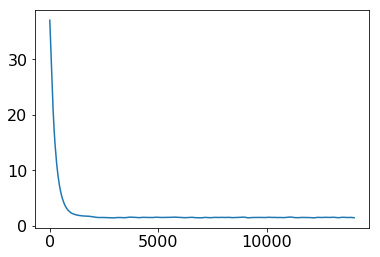

In [179]:
smoothing = True
window_length = 201
polyorder = 1

if smoothing and len(loss_hist) > window_length:
    smooth_loss_hist = savgol_filter(
        loss_hist,
        window_length=window_length,
        polyorder=polyorder)
else:
    smooth_loss_hist = loss_hist


ax = plt.gca()
ax.plot(smooth_loss_hist)

## Exploration

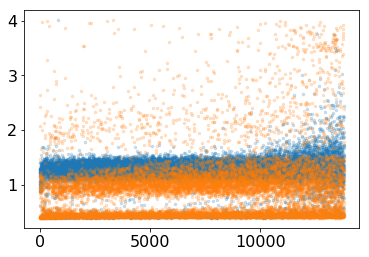

In [180]:
x = fsd_codec.decode(fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")))['mu_hi'] / (
    torch.tensor(sc_fingerprint_datastore.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1))
x = x.detach().cpu().numpy()
plt.plot(x[:, 0], alpha=0.2, lw=0, marker='.', markersize=5)
plt.plot(x[:, 1], alpha=0.2, lw=0, marker='.', markersize=5)
# plt.ylim([0, 5])

mean_e_obs: 207.37343517929133
mu_e_hi (prior): 185.60157775878906
phi_e_hi (prior): 0.0019334444077685475
p_zero_e_hi (prior): 0.00545512093231082
mean_e_hi (prior): 184.58909606933594
mu_lo: tensor([[0.0431]])
phi_lo: tensor([[1.0029]])
w_lo: tensor([[1.]])
mu_hi: tensor([[19.5859,  5.4483]])
phi_hi: tensor([[0.0323, 0.3987]])
w_hi: tensor([[0.5993, 0.4007]])


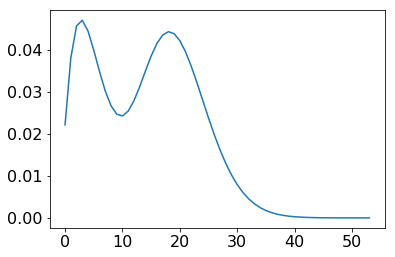

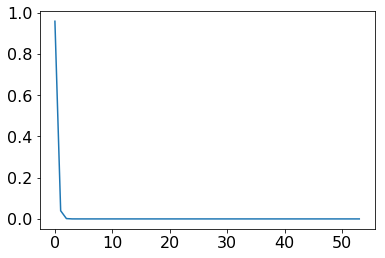

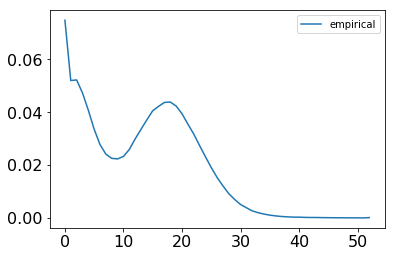

In [181]:
gene_index = 0
# cell_shard_size = 200

# exploration_e_lo_sum_width = training_e_lo_sum_width
# exploration_e_hi_sum_width = training_e_hi_sum_width
# exploration_e_lo_log_prob_prefactor = training_e_lo_log_prob_prefactor
# exploration_e_hi_log_prob_prefactor = training_e_hi_log_prob_prefactor
# exploration_e_obs_log_prob_prefactor = training_e_obs_log_prob_prefactor
# exploration_fingerprint_obs_log_prob_prefactor = training_fingerprint_obs_log_prob_prefactor

# expr_dict = get_expression_map(
#     gene_index, model, sc_fingerprint_datastore,
#     e_lo_sum_width=exploration_e_lo_sum_width,
#     e_hi_sum_width=exploration_e_hi_sum_width,
#     cell_shard_size=cell_shard_size,
#     e_lo_log_prob_prefactor=exploration_e_lo_log_prob_prefactor,
#     e_hi_log_prob_prefactor=exploration_e_hi_log_prob_prefactor,
#     e_obs_log_prob_prefactor=exploration_e_obs_log_prob_prefactor,
#     fingerprint_obs_log_prob_prefactor=exploration_fingerprint_obs_log_prob_prefactor)

# e_lo, e_hi = expr_dict['e_lo_map'], expr_dict['e_hi_map']

fsd_xi_loc = pyro.param("fsd_xi_posterior_loc")[gene_index, :]
fsd_params_dict = fsd_codec.decode(fsd_xi_loc.unsqueeze(0))
dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)

e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_zero=pyro.param("logit_p_zero_e_hi"),
    mu=pyro.param("mu_e_hi"),
    phi=pyro.param("phi_e_hi"))


e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
mean_e_obs = np.mean(e_obs)
# mean_e_hi = np.mean(e_hi)
# mean_e_lo = np.mean(e_lo)
# e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
# print('mean_e_hi (map):', mean_e_hi)
# print('mean_e_lo (map):', mean_e_lo)
# print('e_hi_z:', e_hi_z)
# print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', pyro.param("mu_e_hi")[gene_index].item())
print('phi_e_hi (prior):', pyro.param("phi_e_hi")[gene_index].item())
print('p_zero_e_hi (prior):', torch.sigmoid(pyro.param("logit_p_zero_e_hi")[gene_index]).item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean[gene_index].item())



# fig = plt.figure()
# e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
# plt.scatter(e_obs, e_hi, s=1, alpha=0.5)
# plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
# plt.xlabel('e_obs', fontsize=16)
# plt.ylabel('e_hi', fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((0.1, 2*np.max(e_obs)))
# plt.ylim((0.1, 2*np.max(e_obs)))


# fig = plt.figure()
# plt.scatter(e_obs, expr_dict['mu_e_lo'], alpha=0.5, s=1, label='prior')
# plt.scatter(e_obs, e_lo, alpha=0.5, s=1, label='posterior')
# plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
# plt.xlabel('e_obs', fontsize=16)
# plt.ylabel('e_lo', fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((0.1, 2*np.max(e_obs)))
# plt.ylim((0.1, 2*np.max(e_obs)))
# plt.legend()

# plt.figure()
# _ = plt.hist(e_lo - expr_dict['e_lo_min'], alpha=0.5, range=(0, exploration_e_lo_sum_width), bins=exploration_e_lo_sum_width)
# _ = plt.hist(e_hi - expr_dict['e_hi_min'], alpha=0.5, range=(0, exploration_e_hi_sum_width), bins=exploration_e_hi_sum_width)

for k, v in fsd_params_dict.items():
    print(f"{k}: {v.clone().detach().cpu()}")


fig = plt.figure()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_hi)

fig = plt.figure()
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_lo)


empircal_fsd = sc_fingerprint_datastore.fingerprint_array[:, gene_index, :]
empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

# model_fsd = e_obs[:, None] * np.exp(expr_dict['fit_log_prob_map'])
# model_fsd = model_fsd / (1e-12 + np.sum(model_fsd, -1)[:, None])
# model_fsd = np.sum(model_fsd, 0)
# model_fsd = model_fsd / np.sum(model_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
# plt.plot(model_fsd, label='model')
plt.legend()

In [182]:
# plt.figure(figsize=(18,4))

# err = np.vstack((expr_dict['e_hi_map'] - expr_dict['e_hi_ci_lower'], expr_dict['e_hi_ci_upper'] - expr_dict['e_hi_map']))
# # err = np.sqrt(expr_dict['e_hi_var'])
# plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), e_obs, marker='o', color='cyan', s=30)
# plt.errorbar(np.arange(0, sc_fingerprint_datastore.n_cells),
#              expr_dict['e_hi_map'],
#              barsabove=True, elinewidth=1, lw=0,
#              marker='.', ecolor='gray', markersize=8,
#              yerr=err, alpha=0.5)
# # plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)


In [183]:
# from collections import Counter
# x_vals = e_obs
# y_vals = expr_dict['e_hi_map']
# combos = list(zip(x_vals, y_vals))
# weight_counter = Counter(combos)
# weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


# plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
# plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
# plt.ylabel(r'$e^>$', fontsize=16)
# plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

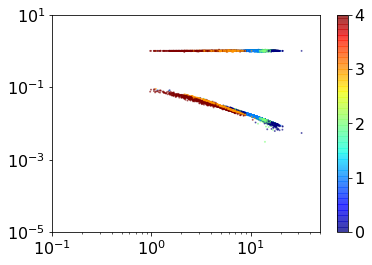

In [184]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
assignments = torch.argmin(
    (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).unsqueeze(-1)
     - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze() / mu_hi.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-5, 10.))
plt.xlim((0.1, 50)) 
plt.colorbar()

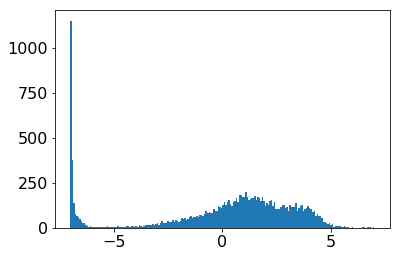

In [185]:
logit_p_zero_e_hi = pyro.param("logit_p_zero_e_hi").detach().cpu().numpy()
_ = plt.hist(logit_p_zero_e_hi, bins=200)

## Visualizing the distributions parameters $\xi$

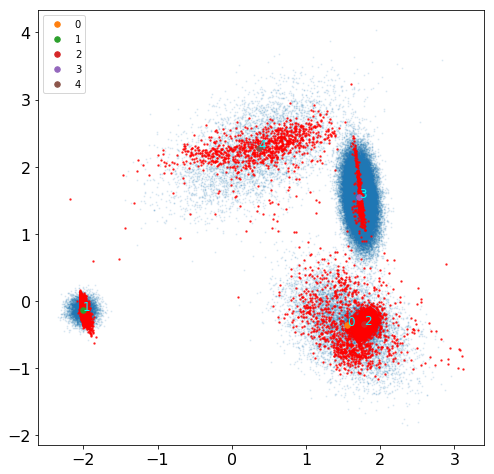

In [186]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution
from sklearn.decomposition import PCA

n_prior_samples = 100_000

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).detach().cpu().numpy()
    
    fsd_xi_prior_locs = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs"))
    fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales")
    fsd_xi_prior_dist = model.get_fsd_xi_prior_dist(fsd_xi_prior_locs, fsd_xi_prior_scales)
    xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()
    

pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_posterior)
xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs").detach().cpu().numpy())


fig = plt.figure(figsize=(8, 8))
plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.1, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.7, s=2, color='red')
for j in range(model.fsd_gmm_num_components):
    plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
    plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
plt.legend()


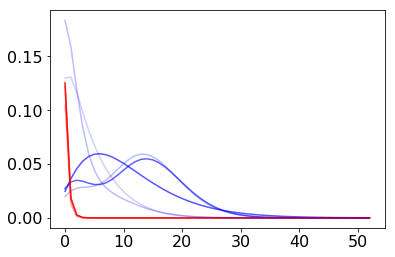

In [187]:
fig = plt.figure()

for fsd_gmm_comp_idx in range(5):
    fsd_xi = pyro.param("fsd_xi_prior_locs")[fsd_gmm_comp_idx, :]
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(fsd_xi), None)
    max_fs = sc_fingerprint_datastore.max_family_size + 1

    p_hi = dist_hi.log_prob(torch.arange(1, max_fs
                                        ).float().cuda()).detach().cpu().exp().numpy().flatten()
    p_lo = dist_lo.log_prob(torch.arange(1, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
    plt.plot(p_hi, color='blue', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))
    plt.plot(p_lo, color='red', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))